In [1]:
# ============================================================================
# CELL 1: Environment Setup and GPU Check
# ============================================================================
import os
import sys
import torch
import warnings
warnings.filterwarnings('ignore')

# Check GPU
print("🔍 GPU Information:")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"CUDA Version: {torch.version.cuda}")

# Set memory optimization for P100
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'
torch.cuda.empty_cache()

🔍 GPU Information:
CUDA Available: True
GPU Name: Tesla P100-PCIE-16GB
GPU Memory: 17.06 GB
CUDA Version: 12.4


In [2]:
%%time
# ============================================================================
# CELL 2: Install Dependencies (Exact Match to Working Setup)
# ============================================================================


# Install in correct order
!pip install -q "transformers==4.46.3" "tokenizers==0.20.3" einops addict easydict pillow gradio

!pip install -q pandas numpy tqdm matplotlib seaborn scikit-learn accelerate

print("\n✅ All dependencies installed")
print("⚠️ RESTART KERNEL and run from CELL 1")



✅ All dependencies installed
⚠️ RESTART KERNEL and run from CELL 1
CPU times: user 71.9 ms, sys: 37.5 ms, total: 109 ms
Wall time: 6.76 s


In [3]:
%%time
# ============================================================================
# CELL 3: Clone Tversky Implementation from GitHub
# ============================================================================

import os
import sys

# Clone repository if not exists
if not os.path.exists('DeepSeek-OCR'):
    !git clone https://github.com/avishadilhara/DeepSeek-OCR.git
    print("✅ Repository cloned")
else:
    print("✅ Repository already exists")

# Add to Python path
sys.path.insert(0, '/kaggle/working/DeepSeek-OCR/DeepSeek-OCR-master/DeepSeek-OCR-vllm')
sys.path.insert(0, '/kaggle/working/DeepSeek-OCR')

print("✅ Python path configured")

Cloning into 'DeepSeek-OCR'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 90 (delta 17), reused 36 (delta 13), pack-reused 46 (from 1)
Receiving objects: 100% (90/90), 8.25 MiB | 36.43 MiB/s, done.
Resolving deltas: 100% (27/27), done.
✅ Repository cloned
✅ Python path configured
CPU times: user 12.4 ms, sys: 14.3 ms, total: 26.7 ms
Wall time: 852 ms


In [4]:
# ============================================================================
# CELL 4: Import Tversky Modules
# ============================================================================
from tversky.layers import TverskyProjection, TverskyLMHead
from tversky.integration import convert_decoder_to_tversky
from tversky.training_utils import (
    TverskyTrainingConfig,
    SINHALA_OCR_TVERSKY_CONFIG,
    create_tversky_optimizer,
    get_tversky_regularization_loss,
    analyze_tversky_parameters,
    monitor_tversky_health
)
from tversky.feature_banks import SinhalaFeatureBank

print("✅ Tversky modules imported successfully")

✅ Tversky modules imported successfully


📊 Dataset Statistics:
Total samples: 400
Avg characters: 1835
Avg words: 310
Image dimensions: 1729x2846
✅ Saved dataset samples visualization


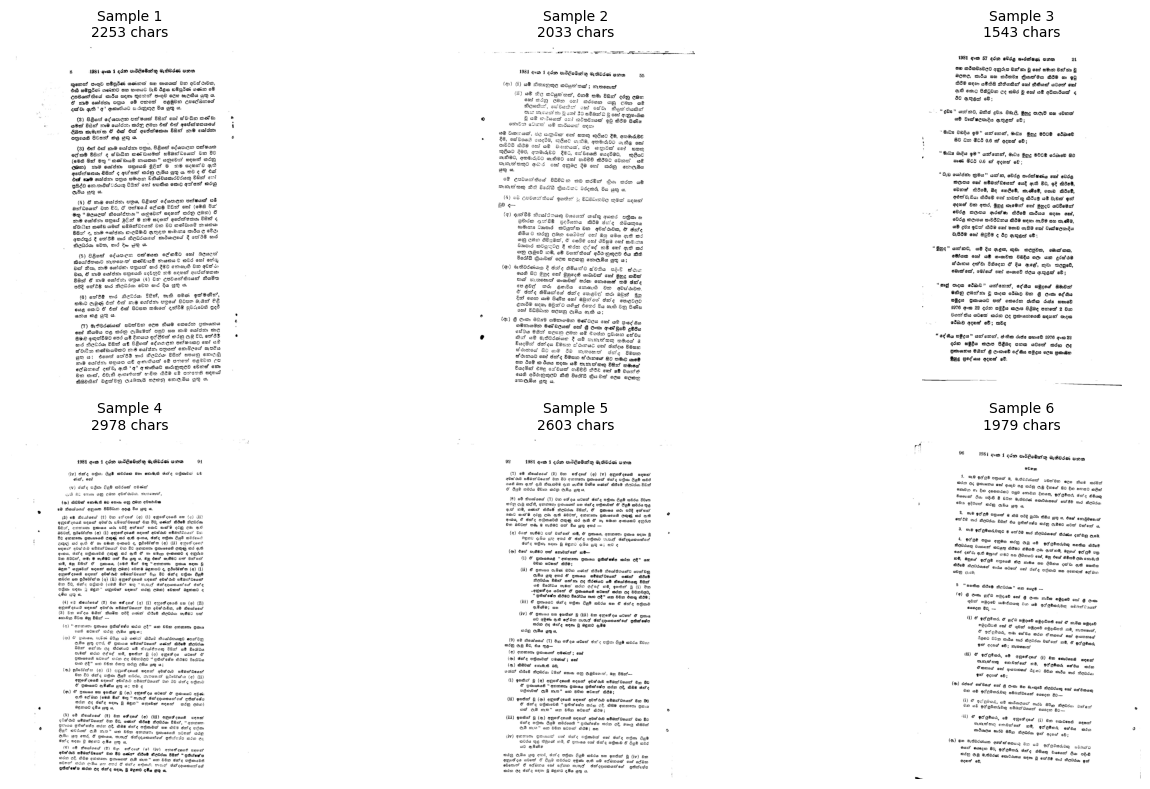

In [5]:
# ============================================================================
# CELL 5: Load and Analyze Dataset
# ============================================================================
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

# Load annotations
df = pd.read_csv('/kaggle/input/sinhala-printed-text-dataset-400/annotations.csv')
IMAGE_DIR = Path('/kaggle/input/sinhala-printed-text-dataset-400/images')

print(f"📊 Dataset Statistics:")
print(f"Total samples: {len(df)}")
print(f"Avg characters: {df['character_count'].mean():.0f}")
print(f"Avg words: {df['word_count'].mean():.0f}")
print(f"Image dimensions: {df['image_width'].mean():.0f}x{df['image_height'].mean():.0f}")

# Visualize sample
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for idx, ax in enumerate(axes.flat):
    if idx < len(df):
        img_path = IMAGE_DIR / df.iloc[idx]['image_filename']
        if img_path.exists():
            img = Image.open(img_path)
            ax.imshow(img)
            ax.set_title(f"Sample {idx+1}\n{df.iloc[idx]['character_count']} chars", 
                        fontsize=10)
            ax.axis('off')
plt.tight_layout()
plt.savefig('dataset_samples.png', dpi=150, bbox_inches='tight')
print("✅ Saved dataset samples visualization")

In [6]:
# ============================================================================
# CELL 6: Create Train/Val Split
# ============================================================================
from sklearn.model_selection import train_test_split

# Stratified split based on text length bins
df['length_bin'] = pd.cut(df['character_count'], bins=5, labels=False)

train_df, val_df = train_test_split(
    df, 
    test_size=0.15,  # 60 samples for validation
    stratify=df['length_bin'],
    random_state=42
)

print(f"📦 Split:")
print(f"  Training: {len(train_df)} samples")
print(f"  Validation: {len(val_df)} samples")
print(f"\nTraining set character distribution:")
print(train_df['character_count'].describe())

# Save splits
train_df.to_csv('train_split.csv', index=False)
val_df.to_csv('val_split.csv', index=False)

📦 Split:
  Training: 340 samples
  Validation: 60 samples

Training set character distribution:
count     340.000000
mean     1829.558824
std       386.307556
min       937.000000
25%      1569.000000
50%      1776.000000
75%      2012.000000
max      3198.000000
Name: character_count, dtype: float64


In [7]:
# ============================================================================
# CELL 7: Custom Dataset Class for Sinhala OCR (DeepSeek-OCR compatible)
# ============================================================================
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn.functional as F
from PIL import Image, ImageOps
import numpy as np

class SinhalaOCRDataset(Dataset):
    """Sinhala OCR Dataset optimized for P100 GPU - DeepSeek-OCR compatible"""
    
    def __init__(self, df, image_dir, tokenizer, max_length=2048, 
                 base_size=1024, augment=False):
        self.df = df.reset_index(drop=True)
        self.image_dir = Path(image_dir)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.base_size = base_size  # DeepSeek-OCR uses 1024 for Gundam config
        self.augment = augment
        
        # DeepSeek-OCR normalization values (NOT ImageNet!)
        self.mean = np.array([0.5, 0.5, 0.5])
        self.std = np.array([0.5, 0.5, 0.5])
        
    def __len__(self):
        return len(self.df)
    
    def transform_image(self, image):
        """Transform PIL image to tensor matching DeepSeek-OCR preprocessing"""
        # Pad image to base_size x base_size (matching DeepSeek-OCR's ImageOps.pad)
        # Use gray padding (0.5 * 255 = 127.5 ~ 128)
        pad_color = tuple(int(x * 255) for x in self.mean)  # (127, 127, 127)
        image = ImageOps.pad(image, (self.base_size, self.base_size), color=pad_color)
        
        # Convert to numpy array and normalize to [0, 1]
        img_array = np.array(image).astype(np.float32) / 255.0
        
        # Normalize with DeepSeek-OCR stats: (x - 0.5) / 0.5 = 2x - 1
        img_array = (img_array - self.mean) / self.std
        
        # Convert to tensor and transpose to [C, H, W]
        img_tensor = torch.from_numpy(img_array).permute(2, 0, 1).float()
        
        return img_tensor
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load image
        img_path = self.image_dir / row['image_filename']
        image = Image.open(img_path).convert('RGB')
        
        # Apply transforms
        image = self.transform_image(image)
        
        # Tokenize text
        text = row['text_content']
        # Add OCR prompt format (matching DeepSeek-OCR format)
        prompt = "<image>\nFree OCR."
        full_text = prompt + text
        
        # Tokenize
        encoding = self.tokenizer(
            full_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'image': image,
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': encoding['input_ids'].squeeze(0),  # For causal LM
            'text': text,
            'image_id': row['image_id']
        }

print("✅ Dataset class defined (DeepSeek-OCR compatible)")

✅ Dataset class defined (DeepSeek-OCR compatible)


In [8]:
%%time
# ============================================================================
# CELL 8: Load Base DeepSeek-OCR Model
# ============================================================================

import os
import torch
import gc
import warnings
from PIL import Image
from transformers import AutoModel, AutoTokenizer

# Suppress warnings
warnings.filterwarnings('ignore', category=UserWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Free memory
torch.cuda.empty_cache()
gc.collect()

model_id = "deepseek-ai/DeepSeek-OCR"
device = 'cuda'

print(f"\n📥 Loading DeepSeek-OCR model...")
print(f"⚠️ This will download ~6.67GB")
print("=" * 60)

# Load tokenizer
print("\n🔧 Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

if tokenizer.pad_token is None and tokenizer.eos_token is not None:
    tokenizer.pad_token = tokenizer.eos_token

print("✅ Tokenizer loaded successfully")

# Load model in FLOAT32 - important for vision encoder compatibility
# autocast will handle mixed precision during training
print("\n📦 Loading model weights...")
base_model = AutoModel.from_pretrained(
    model_id,
    trust_remote_code=True,
    use_safetensors=True,
    attn_implementation="eager",
    torch_dtype=torch.float32,  # Use float32 for vision encoder compatibility
    low_cpu_mem_usage=True,
    device_map='auto'
)

base_model.eval()

print("\n✅ Model loaded successfully!")
print(f"📊 Model size: {sum(p.numel() for p in base_model.parameters()) / 1e6:.1f}M parameters")
print("📋 Dtype: float32 (autocast handles mixed precision)")

if torch.cuda.is_available():
    print(f"💾 GPU Memory: {torch.cuda.memory_allocated() / 1e9:.2f} GB allocated")


📥 Loading DeepSeek-OCR model...
⚠️ This will download ~6.67GB

🔧 Loading tokenizer...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

✅ Tokenizer loaded successfully

📦 Loading model weights...


config.json: 0.00B [00:00, ?B/s]

modeling_deepseekocr.py: 0.00B [00:00, ?B/s]

conversation.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/deepseek-ai/DeepSeek-OCR:
- conversation.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_deepseekv2.py: 0.00B [00:00, ?B/s]

configuration_deepseek_v2.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/deepseek-ai/DeepSeek-OCR:
- configuration_deepseek_v2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/deepseek-ai/DeepSeek-OCR:
- modeling_deepseekv2.py
- configuration_deepseek_v2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


deepencoder.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/deepseek-ai/DeepSeek-OCR:
- deepencoder.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/deepseek-ai/DeepSeek-OCR:
- modeling_deepseekocr.py
- conversation.py
- modeling_deepseekv2.py
- deepencoder.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
E0000 00:00:1768227456.611836     128 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768227456.665435     128 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-000001.safetensors:   0%|          | 0.00/6.67G [00:00<?, ?B/s]

Some weights of DeepseekOCRForCausalLM were not initialized from the model checkpoint at deepseek-ai/DeepSeek-OCR and are newly initialized: ['model.vision_model.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✅ Model loaded successfully!
📊 Model size: 3336.1M parameters
📋 Dtype: float32 (autocast handles mixed precision)
💾 GPU Memory: 13.37 GB allocated
CPU times: user 1min 30s, sys: 36.7 s, total: 2min 7s
Wall time: 1min 2s


In [9]:
# ============================================================================
# CELL 9: Configure Tversky for Sinhala OCR
# ============================================================================

# Create custom config for P100 16GB GPU
config = TverskyTrainingConfig(
    # Architecture - optimized for P100
    num_features=256,  # Start conservative
    conversion_strategy='lm_head_only',  # Safest approach
    feature_reduction='sum',
    feature_activation='softplus',
    use_smooth_min=True,
    smooth_min_temperature=0.5,
    
    # Tversky initialization (tuned for Sinhala)
    init_alpha=0.3,  # Less weight on input distinctive features
    init_beta=0.7,   # More weight on prototype distinctive features
    init_gamma=15.0, # Scale factor
    
    # Training (P100 optimized)
    base_lr=3e-5,  # Lower LR for stability
    tversky_lr_multiplier=0.05,
    warmup_steps=100,
    max_epochs=10,
    
    # Regularization
    diversity_weight=0.02,
    sparsity_weight=0.001,
    freeze_tversky_epochs=1,
)

print("🔧 Tversky Configuration:")
print(f"  Features: {config.num_features}")
print(f"  Strategy: {config.conversion_strategy}")
print(f"  Alpha: {config.init_alpha}, Beta: {config.init_beta}, Gamma: {config.init_gamma}")
print(f"  Base LR: {config.base_lr}")
print(f"  Max Epochs: {config.max_epochs}")

🔧 Tversky Configuration:
  Features: 256
  Strategy: lm_head_only
  Alpha: 0.3, Beta: 0.7, Gamma: 15.0
  Base LR: 3e-05
  Max Epochs: 10


In [10]:
%%time
# ============================================================================
# CELL 10: Convert to Tversky Model (float32 version)
# ============================================================================

# Configuration for conversion
tversky_config = {
    'hidden_size': 2048,  # DeepSeek-OCR hidden size
    'vocab_size': 102400,  # DeepSeek-OCR vocab size
    'tversky_num_features': config.num_features,
    'conversion_strategy': config.conversion_strategy,
    'init_alpha': config.init_alpha,
    'init_beta': config.init_beta,
    'init_gamma': config.init_gamma,
    'feature_activation': config.feature_activation,
    'use_smooth_min': config.use_smooth_min,
    'smooth_min_temperature': config.smooth_min_temperature
}

# Convert model
print("🔄 Converting to Tversky layers...")
print(f"  Strategy: {config.conversion_strategy}")

model = convert_decoder_to_tversky(
    decoder_model=base_model,
    config=tversky_config,
    strategy=config.conversion_strategy
)

# Keep in float32 - autocast handles mixed precision during training
model = model.to(device)  # No dtype conversion

print("✅ Model converted successfully")
print("📋 Model dtype: float32 (autocast handles mixed precision)")

# Analyze conversion
from tversky.integration import count_tversky_parameters, get_tversky_layers

param_stats = count_tversky_parameters(model)
tversky_layers = get_tversky_layers(model)

print(f"\n📊 Conversion Statistics:")
print(f"  Total parameters: {param_stats['total_params']:,}")
print(f"  Tversky parameters: {param_stats['tversky_params']:,}")
print(f"  Other parameters: {param_stats['other_params']:,}")
print(f"  Tversky ratio: {param_stats['tversky_ratio']:.2%}")
print(f"  Tversky layers found: {len(tversky_layers)}")

# Check memory after conversion
if torch.cuda.is_available():
    print(f"\n💾 GPU Memory After Conversion:")
    print(f"  Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"  Available: {(16 - torch.cuda.memory_allocated() / 1e9):.2f} GB")

print("\n✅ Model ready for training!")

🔄 Converting to Tversky layers...
  Strategy: lm_head_only
Converted LM head to Tversky projection
  Original params: 165,478,400
  Tversky params: 26,738,691
  Reduction: 83.8%
✅ Model converted successfully
📋 Model dtype: float32 (autocast handles mixed precision)

📊 Conversion Statistics:
  Total parameters: 3,198,939,395
  Tversky parameters: 26,738,691
  Other parameters: 3,172,200,704
  Tversky ratio: 0.84%
  Tversky layers found: 2

💾 GPU Memory After Conversion:
  Allocated: 12.82 GB
  Available: 3.18 GB

✅ Model ready for training!
CPU times: user 289 ms, sys: 74.5 ms, total: 364 ms
Wall time: 462 ms


In [11]:
# ============================================================================
# CELL 11: Create Data Loaders
# ============================================================================

# Create datasets with DeepSeek-OCR compatible settings
train_dataset = SinhalaOCRDataset(
    train_df, 
    IMAGE_DIR, 
    tokenizer,
    max_length=1024,  # Reduced for P100 memory
    base_size=1024,   # DeepSeek-OCR Gundam config uses 1024
    augment=False
)

val_dataset = SinhalaOCRDataset(
    val_df,
    IMAGE_DIR,
    tokenizer,
    max_length=1024,
    base_size=1024,
    augment=False
)

# Create data loaders (small batch size for P100)
train_loader = DataLoader(
    train_dataset,
    batch_size=1,  # Very small for P100 16GB
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"✅ Data loaders created")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Batch size: 1 (P100 optimized)")
print(f"  Image size: {train_dataset.base_size}x{train_dataset.base_size}")

✅ Data loaders created
  Train batches: 340
  Val batches: 60
  Batch size: 1 (P100 optimized)
  Image size: 1024x1024


In [12]:
# ============================================================================
# CELL 12: Setup Training
# ============================================================================
from torch.cuda.amp import autocast, GradScaler

# Create optimizer with differential learning rates
optimizer = create_tversky_optimizer(
    model,
    base_lr=config.base_lr,
    tversky_lr_multiplier=config.tversky_lr_multiplier,
    weight_decay=0.01
)

# Learning rate scheduler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

scheduler = CosineAnnealingWarmRestarts(
    optimizer,
    T_0=len(train_loader),
    T_mult=2,
    eta_min=1e-7
)

# Gradient scaler for mixed precision
scaler = GradScaler()

print("✅ Training setup complete")
print(f"  Optimizer: AdamW with differential LR")
print(f"  Scheduler: CosineAnnealingWarmRestarts")
print(f"  Mixed Precision: Enabled (FP16)")

✅ Training setup complete
  Optimizer: AdamW with differential LR
  Scheduler: CosineAnnealingWarmRestarts
  Mixed Precision: Enabled (FP16)


In [ ]:
# ============================================================================
# CELL 13: Image Preprocessing for DeepSeek-OCR (Gundam Config)
# ============================================================================

def prepare_deepseek_images(images_batch, input_ids, tokenizer, base_size=1024, image_size=640):
    """
    Prepare images for DeepSeek-OCR model with Gundam configuration.

    CRITICAL: DeepSeek-OCR expects:
    - images = [(patches_tensor, global_tensor), ...] as list of tuples
    - images_seq_mask must match input_ids length, with True at image token positions

    Args:
        images_batch: Tensor of shape [B, C, H, W]
        input_ids: Tensor of shape [B, seq_len] - needed for mask sizing
        tokenizer: Tokenizer (kept for compatibility; not used directly here)
        base_size: Base size for global view (1024 for Gundam)
        image_size: Size for patches (640 for Gundam)

    Returns:
        dict with images, images_seq_mask, images_spatial_crop
    """
    batch_size = images_batch.shape[0]
    seq_len = input_ids.shape[1]  # Mask must match input sequence length
    device = images_batch.device

    # Keep in float32 - let autocast handle mixed precision
    dtype = torch.float32
    images_batch = images_batch.to(dtype=dtype)

    processed_images = []

    for i in range(batch_size):
        # Get single image [C, H, W]
        single_image = images_batch[i]

        # Global view: [C, H, W] -> [1, C, H, W]
        global_view = single_image.unsqueeze(0)

        # Patches: zeros placeholder for no dynamic cropping
        patches = torch.zeros((1, 3, image_size, image_size), dtype=dtype, device=device)

        # DeepSeek-OCR expects tuple: (patches, global_view)
        processed_images.append((patches, global_view))

    # images_spatial_crop: crop ratios [B, 2] - (1,1) means no cropping
    images_spatial_crop = torch.tensor(
        [[1, 1] for _ in range(batch_size)],
        dtype=torch.long,
        device=device
    )

    # Vision encoder (Gundam config) outputs 256 image tokens
    num_image_tokens = 256

    # Create sequence mask matching input_ids length
    images_seq_mask = torch.zeros(
        (batch_size, seq_len),
        dtype=torch.bool,
        device=device
    )
    images_seq_mask[:, :num_image_tokens] = True

    return {
        "images": processed_images,
        "images_spatial_crop": images_spatial_crop,
        "images_seq_mask": images_seq_mask
    }

print("✅ Image preprocessing helper defined (mask matches input_ids length)")

✅ Image preprocessing helper defined (float32 for vision encoder compatibility)


In [14]:
# ============================================================================
# CELL 14: Training Functions
# ============================================================================

from tqdm.auto import tqdm
import time

def train_epoch(model, train_loader, optimizer, scheduler, scaler, config, epoch, device):
    """Train for one epoch"""
    model.train()
    
    # Freeze Tversky layers if needed
    if epoch < config.freeze_tversky_epochs:
        for module in model.modules():
            if hasattr(module, 'feature_bank'):
                for param in module.parameters():
                    param.requires_grad = False
        print(f"Tversky layers frozen for epoch {epoch+1}")
    else:
        for param in model.parameters():
            param.requires_grad = True
    
    total_loss = 0
    total_reg_loss = 0
    num_batches = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    
    for batch_idx, batch in enumerate(progress_bar):
        # Move to device
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass with mixed precision
        with autocast():
            try:
                # Prepare images with Gundam config
                # Pass input_ids so mask matches sequence length
                image_inputs = prepare_deepseek_images(
                    images,
                    input_ids=input_ids,
                    tokenizer=tokenizer,
                    base_size=1024,
                    image_size=640
                )
                
                # Call model
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels,
                    images=image_inputs['images'],
                    images_spatial_crop=image_inputs['images_spatial_crop'],
                    images_seq_mask=image_inputs['images_seq_mask']
                )
                
                # Get loss
                if hasattr(outputs, 'loss') and outputs.loss is not None:
                    loss = outputs.loss
                elif isinstance(outputs, dict) and 'loss' in outputs:
                    loss = outputs['loss']
                else:
                    print(f"⚠️ No loss in outputs: {type(outputs)}")
                    continue
                
                # Add Tversky regularization
                reg_loss = get_tversky_regularization_loss(
                    model,
                    diversity_weight=config.diversity_weight,
                    sparsity_weight=config.sparsity_weight
                )
                
                total_loss_with_reg = loss + reg_loss
                
            except Exception as e:
                print(f"\n❌ Error in forward pass: {e}")
                import traceback
                traceback.print_exc()
                continue
        
        # Backward pass
        optimizer.zero_grad()
        scaler.scale(total_loss_with_reg).backward()
        
        # Gradient clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Optimizer step
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        
        # Logging
        total_loss += loss.item()
        total_reg_loss += reg_loss.item()
        num_batches += 1
        
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'reg': f'{reg_loss.item():.4f}',
            'lr': f'{optimizer.param_groups[0]["lr"]:.2e}'
        })
        
        # Clear cache periodically
        if batch_idx % 10 == 0:
            torch.cuda.empty_cache()
    
    avg_loss = total_loss / num_batches if num_batches > 0 else 0
    avg_reg_loss = total_reg_loss / num_batches if num_batches > 0 else 0
    
    return avg_loss, avg_reg_loss


def validate(model, val_loader, device):
    """Validate the model"""
    model.eval()
    total_loss = 0
    num_batches = 0
    
    progress_bar = tqdm(val_loader, desc="Validation")
    
    with torch.no_grad():
        for batch in progress_bar:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            with autocast():
                try:
                    # Prepare images with Gundam config
                    # Pass input_ids so mask matches sequence length
                    image_inputs = prepare_deepseek_images(
                        images,
                        input_ids=input_ids,
                        tokenizer=tokenizer,
                        base_size=1024,
                        image_size=640
                    )
                    
                    outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels,
                        images=image_inputs['images'],
                        images_spatial_crop=image_inputs['images_spatial_crop'],
                        images_seq_mask=image_inputs['images_seq_mask']
                    )
                    
                    if hasattr(outputs, 'loss') and outputs.loss is not None:
                        loss = outputs.loss
                    elif isinstance(outputs, dict) and 'loss' in outputs:
                        loss = outputs['loss']
                    else:
                        continue
                        
                    total_loss += loss.item()
                    num_batches += 1
                    
                except Exception as e:
                    print(f"\n❌ Error in validation: {e}")
                    continue
            
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / num_batches if num_batches > 0 else 0
    return avg_loss

print("✅ Training functions defined")

✅ Training functions defined


In [ ]:
%%time
# CELL 14: Training Loop 

# Training history
history = {
    'train_loss': [],
    'train_reg_loss': [],
    'val_loss': [],
    'epoch_time': []
}

best_val_loss = float('inf')
patience_counter = 0
patience = 3

print("\n" + "="*60)
print(f"Starting training... for {config.max_epochs} epochs")
print("="*60)

for epoch in range(config.max_epochs):
    epoch_start = time.time()
    
    # Train
    train_loss, train_reg_loss = train_epoch(
        model, train_loader, optimizer, scheduler, scaler, config, epoch, device
    )
    
    # Validate
    val_loss = validate(model, val_loader, device)
    
    # Record history
    epoch_time = time.time() - epoch_start
    history['train_loss'].append(train_loss)
    history['train_reg_loss'].append(train_reg_loss)
    history['val_loss'].append(val_loss)
    history['epoch_time'].append(epoch_time)
    
    # Print epoch summary
    print(f"\nEpoch {epoch+1}/{config.max_epochs} Summary:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Train Reg Loss: {train_reg_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Time: {epoch_time/60:.1f} min")
    print(f"  GPU Memory: {torch.cuda.memory_allocated()/1e9:.2f} GB")
    
    # FIXED: Check model health only every 3 epochs to save memory
    if (epoch + 1) % 3 == 0:
        warnings_list = []
        try:
            warnings_list = monitor_tversky_health(model)
        except Exception as e:
            print(f"⚠️ Health monitoring failed: {e}")
            warnings_list = []
        
        if warnings_list:
            print(f"⚠️ Warnings: {len(warnings_list)}")
            for w in warnings_list[:3]:  # Show first 3
                print(f"  - {w}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        
        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'config': config.to_dict()
        }, 'best_tversky_sinhala_ocr.pt')
        
        print(f"✅ Best model saved (val_loss: {val_loss:.4f})")
    else:
        patience_counter += 1
        print(f"Patience: {patience_counter}/{patience}")
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\n🛑 Early stopping triggered at epoch {epoch+1}")
        break
    
    # Analyze Tversky parameters every 2 epochs
    if (epoch + 1) % 2 == 0:
        try:
            analysis = analyze_tversky_parameters(model)
            print(f"\n📊 Tversky Analysis:")
            for name, stats in list(analysis.items())[:2]:  # Show first 2 layers
                print(f"  {name}:")
                print(f"    α={stats['alpha']:.3f}, β={stats['beta']:.3f}, γ={stats['gamma']:.3f}")
        except Exception as e:
            print(f"⚠️ Parameter analysis failed: {e}")
    
    print("="*60)

print("\n" + "="*60)
print("🎉 Training complete!")
print("="*60)



Starting training... for 10 epochs
Tversky layers frozen for epoch 1


Epoch 1:   0%|          | 0/340 [00:00<?, ?it/s]


❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^


❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^


❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^


❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^


❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^


❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^


❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^


❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^


❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^


❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^


❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^


❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^


❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^


❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^


❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^


❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^


❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^


❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^


❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^


❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^


❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^


❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^


❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^


❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'
Traceback (most recent call last):
  File "/tmp/ipykernel_128/2455789669.py", line 40, in train_epoch
    image_inputs = prepare_deepseek_images(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'



❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'

❌ Error in forward pass: prepare_deepseek_images() got an unexpected keyword argument 'input_ids'


In [ ]:
# ============================================================================
# CELL 15: Plot Training History
# ============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss curves
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Regularization loss
axes[1].plot(history['train_reg_loss'], label='Reg Loss', marker='o', color='orange')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Regularization Loss')
axes[1].set_title('Tversky Regularization Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Epoch time
axes[2].bar(range(len(history['epoch_time'])), 
           [t/60 for t in history['epoch_time']], 
           color='green', alpha=0.7)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Time (minutes)')
axes[2].set_title('Epoch Training Time')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
print("✅ Saved training history plot")

In [ ]:
# ============================================================================
# CELL 16: Load Best Model and Test
# ============================================================================

# Load best checkpoint
checkpoint = torch.load('best_tversky_sinhala_ocr.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✅ Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"   Best validation loss: {checkpoint['val_loss']:.4f}")

In [ ]:
# ============================================================================
# CELL 17: Inference Function (DeepSeek-OCR compatible)
# ============================================================================
import numpy as np
from PIL import Image, ImageOps

def infer_ocr(model, tokenizer, image_path, device, max_length=1024, base_size=1024):
    """Run OCR inference on a single image - DeepSeek-OCR compatible"""
    model.eval()
    
    # Load and preprocess image matching DeepSeek-OCR
    image = Image.open(image_path).convert('RGB')
    
    # DeepSeek-OCR normalization values
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    
    # Pad image to base_size x base_size (matching DeepSeek-OCR's ImageOps.pad)
    pad_color = tuple(int(x * 255) for x in mean)  # (127, 127, 127)
    image = ImageOps.pad(image, (base_size, base_size), color=pad_color)
    
    # Convert to numpy and normalize
    img_array = np.array(image).astype(np.float32) / 255.0
    
    # Normalize with DeepSeek-OCR stats
    img_array = (img_array - mean) / std
    
    # Convert to tensor [C, H, W] and add batch dimension
    image_tensor = torch.from_numpy(img_array).permute(2, 0, 1).unsqueeze(0)
    image_tensor = image_tensor.to(device).to(torch.float32)  # Keep float32 for vision encoder
    
    # Create prompt and get input_ids first (needed for mask sizing)
    prompt = "<image>\nFree OCR."
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    
    # Pad input_ids to max_length for proper mask creation
    if input_ids.shape[1] < max_length:
        padding = torch.full(
            (1, max_length - input_ids.shape[1]), 
            tokenizer.pad_token_id, 
            dtype=input_ids.dtype, 
            device=device
        )
        input_ids_padded = torch.cat([input_ids, padding], dim=1)
    else:
        input_ids_padded = input_ids[:, :max_length]
    
    # Prepare image inputs with DeepSeek-OCR format
    image_inputs = prepare_deepseek_images(
        image_tensor,
        input_ids=input_ids_padded,
        tokenizer=tokenizer,
        base_size=base_size,
        image_size=640
    )
    
    # Generate
    with torch.no_grad():
        with autocast():
            try:
                # Try using model.generate if available
                if hasattr(model, 'generate'):
                    outputs = model.generate(
                        input_ids=input_ids_padded,
                        images=image_inputs['images'],
                        images_spatial_crop=image_inputs['images_spatial_crop'],
                        images_seq_mask=image_inputs['images_seq_mask'],
                        max_length=max_length,
                        num_beams=1,
                        do_sample=False
                    )
                    
                    # Decode
                    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
                    # Remove prompt
                    generated_text = generated_text.replace(prompt, "").strip()
                    
                    return generated_text
                else:
                    # Fallback: use forward pass and greedy decoding
                    outputs = model(
                        input_ids=input_ids_padded,
                        images=image_inputs['images'],
                        images_spatial_crop=image_inputs['images_spatial_crop'],
                        images_seq_mask=image_inputs['images_seq_mask']
                    )
                    
                    if hasattr(outputs, 'logits'):
                        # Greedy decoding from logits
                        predicted_ids = outputs.logits.argmax(dim=-1)
                        generated_text = tokenizer.decode(predicted_ids[0], skip_special_tokens=True)
                        return generated_text
                    
                    return None
                    
            except Exception as e:
                print(f"Error during inference: {e}")
                import traceback
                traceback.print_exc()
                return None

print("✅ Inference function defined (DeepSeek-OCR compatible)")

In [ ]:
# ============================================================================
# CELL 18: Test on Validation Set
# ============================================================================
from difflib import SequenceMatcher
import re

def calculate_character_accuracy(pred, gt):
    """Calculate character-level accuracy"""
    matcher = SequenceMatcher(None, pred, gt)
    return matcher.ratio()

def calculate_word_accuracy(pred, gt):
    """Calculate word-level accuracy"""
    pred_words = pred.split()
    gt_words = gt.split()
    
    if len(gt_words) == 0:
        return 0.0
    
    correct = sum(1 for p, g in zip(pred_words, gt_words) if p == g)
    return correct / len(gt_words)

# Test on validation samples
test_samples = val_df.head(10)  # Test on first 10
results = []

print("🧪 Testing on validation samples...\n")

for idx, row in test_samples.iterrows():
    img_path = IMAGE_DIR / row['image_filename']
    ground_truth = row['text_content']
    
    print(f"Sample {idx+1}/{len(test_samples)}: {row['image_filename']}")
    
    # Run inference
    prediction = infer_ocr(model, tokenizer, img_path, device)
    
    if prediction:
        # Calculate metrics
        char_acc = calculate_character_accuracy(prediction, ground_truth)
        word_acc = calculate_word_accuracy(prediction, ground_truth)
        
        results.append({
            'image_id': row['image_id'],
            'image_filename': row['image_filename'],
            'char_accuracy': char_acc,
            'word_accuracy': word_acc,
            'prediction_length': len(prediction),
            'gt_length': len(ground_truth)
        })
        
        print(f"  Char Accuracy: {char_acc:.2%}")
        print(f"  Word Accuracy: {word_acc:.2%}")
        print(f"  Predicted length: {len(prediction)} chars")
        print(f"  Ground truth length: {len(ground_truth)} chars")
        print()

# Create results dataframe
results_df = pd.DataFrame(results)
results_df.to_csv('test_results.csv', index=False)

print("📊 Test Results Summary:")
print(f"  Avg Character Accuracy: {results_df['char_accuracy'].mean():.2%}")
print(f"  Avg Word Accuracy: {results_df['word_accuracy'].mean():.2%}")
print(f"  Median Char Accuracy: {results_df['char_accuracy'].median():.2%}")
print("✅ Results saved to test_results.csv")

In [ ]:
# ============================================================================
# CELL 19: Visualize Predictions
# ============================================================================
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flat

for idx, (_, row) in enumerate(test_samples.head(6).iterrows()):
    img_path = IMAGE_DIR / row['image_filename']
    img = Image.open(img_path)
    
    # Get results
    result = results_df[results_df['image_id'] == row['image_id']].iloc[0]
    
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(
        f"ID: {row['image_id']} | Char Acc: {result['char_accuracy']:.1%}\n"
        f"Word Acc: {result['word_accuracy']:.1%}",
        fontsize=10
    )

plt.tight_layout()
plt.savefig('test_predictions.png', dpi=150, bbox_inches='tight')
print("✅ Saved prediction visualizations")


In [ ]:
# ============================================================================
# CELL 20: Save Final Model and Config
# ============================================================================

# Save Tversky weights only
tversky_state = {}
tversky_keys = {'alpha_raw', 'beta_raw', 'gamma', 'feature_bank', 'prototype_bank'}

for name, param in model.named_parameters():
    if any(k in name for k in tversky_keys):
        tversky_state[name] = param.data.cpu()

# Save final checkpoint
final_checkpoint = {
    'tversky_state_dict': tversky_state,
    'full_model_state_dict': model.state_dict(),
    'config': config.to_dict(),
    'training_history': history,
    'test_results': results_df.to_dict(),
    'param_stats': param_stats,
    'best_val_loss': best_val_loss
}

torch.save(final_checkpoint, 'final_tversky_sinhala_ocr.pt')

print("✅ Saved final model checkpoint")
print(f"📦 Checkpoint includes:")
print(f"  - Tversky layer weights")
print(f"  - Full model state dict")
print(f"  - Training configuration")
print(f"  - Training history")
print(f"  - Test results")

# Save config separately
config.save('tversky_config.json')
print("✅ Saved configuration to tversky_config.json")

In [ ]:
# ============================================================================
# CELL 21: Generate Training Report
# ============================================================================

report = f"""
# Tversky-Enhanced DeepSeek-OCR Training Report
## Sinhala Printed Text Dataset

### Dataset Statistics
- Total samples: {len(df)}
- Training samples: {len(train_df)}
- Validation samples: {len(val_df)}
- Average characters: {df['character_count'].mean():.0f}
- Average words: {df['word_count'].mean():.0f}

### Model Configuration
- Base model: DeepSeek-OCR
- Tversky features: {config.num_features}
- Conversion strategy: {config.conversion_strategy}
- Alpha: {config.init_alpha}, Beta: {config.init_beta}, Gamma: {config.init_gamma}

### Training Configuration
- Epochs trained: {len(history['train_loss'])}
- Batch size: 1
- Learning rate: {config.base_lr}
- Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}

### Model Parameters
- Total parameters: {param_stats['total_params']:,}
- Tversky parameters: {param_stats['tversky_params']:,}
- Tversky ratio: {param_stats['tversky_ratio']:.2%}

### Training Results
- Best validation loss: {best_val_loss:.4f}
- Final train loss: {history['train_loss'][-1]:.4f}
- Final val loss: {history['val_loss'][-1]:.4f}
- Total training time: {sum(history['epoch_time'])/60:.1f} minutes
- Average epoch time: {np.mean(history['epoch_time'])/60:.1f} minutes

### Test Results (First 10 validation samples)
- Average character accuracy: {results_df['char_accuracy'].mean():.2%}
- Average word accuracy: {results_df['word_accuracy'].mean():.2%}
- Median character accuracy: {results_df['char_accuracy'].median():.2%}

### Files Generated
- best_tversky_sinhala_ocr.pt - Best model checkpoint
- final_tversky_sinhala_ocr.pt - Final model with history
- tversky_config.json - Configuration file
- train_split.csv - Training data split
- val_split.csv - Validation data split
- test_results.csv - Test results
- training_history.png - Training curves
- test_predictions.png - Prediction visualizations
- dataset_samples.png - Dataset samples

### Next Steps
1. Fine-tune hyperparameters based on results
2. Increase num_features if memory allows (512 or 1024)
3. Try 'attention_output' conversion strategy
4. Augment training data
5. Experiment with different Tversky parameters (α, β, γ)

Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

with open('training_report.md', 'w', encoding='utf-8') as f:
    f.write(report)

print(report)
print("\n✅ Training report saved to training_report.md")

# ============================================================================
# END OF NOTEBOOK
# ============================================================================
print("\n" + "="*60)
print("✅ ALL CELLS COMPLETED SUCCESSFULLY!")
print("="*60)
print("\n📋 Summary:")
print("  - Model trained with Tversky layers")
print("  - Best validation loss:", f"{best_val_loss:.4f}")
print("  - Test character accuracy:", f"{results_df['char_accuracy'].mean():.2%}")
print("  - All outputs saved to /kaggle/working/")
print("\n💡 Tip: Download the checkpoint files to continue training elsewhere!")